# Исследование российского рынка наручных часов
В этом исследовании я хочу проанализировать рынок наручных часов в России, так как он сильно поменялся после прекращения продаж от иностранных компаний. Исследование делится на несколько блоков, в кажом из которых (кроме самых первых очевидно) я тестирую определенную гипотезу или отвечают на вопрос - в итоге я получу полное представление о состоянии рынка часов в РФ

Для анализа я выбрал магазин alltime, как один из самых старых и больших на российском рынке

In [34]:
# импорт всех нужных библиотек
import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd
import category_encoders as ce
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
from googletrans import Translator
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium

# Данные
В этом блоке я получаю и обрабатываю данные

In [6]:
# создаю паука, который будет стягивать данные о часах с сайта
class AllTimeSpider(scrapy.Spider):
    name = 'alltime_watches' 
    allowed_domains = ['alltime.ru']
    start_urls = ['https://www.alltime.ru/watch/','https://www.alltime.ru/watch/?PAGEN_1=2']
    for i in range(3,308): # все наручные часы располагаются на 307 страницах 
        start_urls.append(f'https://www.alltime.ru/watch/?PAGEN_1={i}') 
    
    def parse(self, response):
        # Извлекаю данные с помощью селектора - для этого внимательно изучил код страницы сайта
        name=response.css('.catalog-item-link > span::text').extract()
        price=response.css('.catalog-item-price-prices > span::text').extract()
        info=response.css('.catalog-item-features::text').extract()
        
        row_data = zip(name, price, info)
        for item in row_data:
            # создаю словарь с данными: имя, цена и доп информация (механизм, стекло, страна и тп)
            result = {
                'name': item[0].strip(), 
                'price': item[1].strip()[:-2],
                'info': item[2].strip(),
            }

            yield result

In [ ]:
# запускаю скраппинг
process = CrawlerProcess(settings = {
    "FEEDS": {
        "alltime.csv": {"format": "csv"},
    },
})
process.crawl(AllTimeSpider)
process.start()

2024-05-17 19:48:07 [scrapy.utils.log] INFO: Scrapy 2.11.2 started (bot: scrapybot)
2024-05-17 19:48:07 [scrapy.utils.log] INFO: Versions: lxml 5.2.2.0, libxml2 2.11.7, cssselect 1.2.0, parsel 1.9.1, w3lib 2.1.2, Twisted 24.3.0, Python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)], pyOpenSSL 24.1.0 (OpenSSL 3.2.1 30 Jan 2024), cryptography 42.0.7, Platform Windows-10-10.0.22631-SP0
2024-05-17 19:48:07 [scrapy.addons] INFO: Enabled addons:
[]
2024-05-17 19:48:07 [py.warnings] WARNING: C:\Users\alekc\AppData\Local\Programs\Python\Python310\lib\site-packages\scrapy\utils\request.py:254: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

In [2]:
# считываю данные для дальнейшей обработки
data = pd.read_csv("alltime.csv")
data.head()

,name,price,info
0,Olivia Burton OB16US45,15 750,"женские, Англия, кварцевые, 30WR, стекло: мине..."
1,D1 Milano UTBL09,21 000,"женские, Италия, кварцевые, 50WR, стекло: сапф..."
2,D1 Milano CHBJ12,34 750,"мужские, Италия, кварцевые, 50WR, стекло: сапф..."
3,Calvin Klein K3M5115X,14 600,"мужские, США, кварцевые, 30WR, стекло: минерал..."
4,Casio G-SHOCK GM-2100-1AER,30 760,"мужские, японские, кварцевые, 200WR, стекло: м..."


In [22]:
# обработаю данные - разделю бренд и модель, пол, механимз, стекло и тп в разные столбцы
new_data = {
    "brand":[],
    "model": [],
    "price": [],
    "sex": [],
    "country": [],
    "mechanism": [],
    "water resistance": [],
    "glass": [],
}
# не беру в расчет диаметр и толщину часов, 
# так как эти параметры несущественны и работают вкупе со всем внешним видом модели, который проанализировать гораздо сложнее
for i in data.iterrows():
    j = i[1]
    name = j[0].split()
    info = j[2].split(", ")
    new_data["brand"].append(" ".join(name[:-1]))
    new_data["model"].append(name[-1])
    new_data["price"].append(int(''.join(j[1].split())))
    # данные не всегда идут по порядку и не всегда полные
    flag = {
        "sex" : 0,
        "country" : 0,
        "mechanism" : 0,
        "water resistance" : 0,
        "glass" : 0
           } # присутствуют те или иные данные в info
    if len(info) < 5:
        info.extend([""]*(5-len(info))) # дополняем данные пустыми полями, если их не хватает - так проще избежать ошибок
    country = {"швейцарские" : "Швейцария", 
              "японские" : "Япония",
              "российские" : "Россия"
             }
    for k in info[:5]:
        if k:
            if (("муж" in k) or ("жен" in k) or ("дет" in k)) and not flag["sex"]: 
                # есть всего 3 типа: мужские, женские и детские и их комбинации
                flag["sex"] = 1
                new_data["sex"].append(k)
            elif (ord("А") < ord(k[0]) <= ord("Я") or k in country) and not flag["country"]:
                # все страны кроме 3 прилагательных в словаре записываются с заглавной буквы
                flag["country"] = 1
                if k in country:
                    new_data["country"].append(country[k])
                else:
                    new_data["country"].append(k)
            elif (("процессор" in k) or ("механические" in k) or ("кварцевые" in k)) and not flag["mechanism"]:
                # часы бывают кварцевые, механические или электорнные с разными подвидами
                new_data["mechanism"].append(k)
                flag["mechanism"] = 1
            elif ("WR" in k) and not flag["water resistance"]:
                # WR - water resistance 
                if len(k)>10:
                    # иногда попадается формулировка типа: мужские - 50WR
                    new_k = k.split(" - ")
                    new_data["water resistance"].append(new_k[1])
                else:
                    new_data["water resistance"].append(k)
                flag["water resistance"] = 1
            elif ("ое" in k) and not flag["glass"]:
                # все типы стекол обозначаются прилагательными, оканчивающимися на "ое"
                # поэтому все, что не подошло раньше, является обозначением стекла
                new_data["glass"].append(k[8:])
                flag["glass"] = 1
    for key in flag:
        if not flag[key]:
            new_data[key].append("")
watches = pd.DataFrame(new_data)
watches.head()

,brand,model,price,sex,country,mechanism,water resistance,glass
0,Olivia Burton,OB16US45,15750,женские,,кварцевые,30WR,минеральное
1,D1 Milano,UTBL09,21000,женские,Италия,кварцевые,50WR,сапфировое с антибликовым покрытием
2,D1 Milano,CHBJ12,34750,мужские,Италия,кварцевые,50WR,сапфировое с антибликовым покрытием
3,Calvin Klein,K3M5115X,14600,мужские,США,кварцевые,30WR,минеральное
4,Casio G-SHOCK,GM-2100-1AER,30760,мужские,Япония,кварцевые,200WR,минеральное


# Первичный анализ
Проведем первичный анализ рынка и заодно протестируем гипотезу

Гипотеза - наиболее популярными должны быть более дорогие часы (как минимум для affluent клиента), так как более дешевый сегмент занят смарт браслетами и часами

In [23]:
# сгруппируем данные по бренду и полу, выделив наиболее информативные группировки для остальных столбцов 
agg_params = {
    "model" : ["count"],
    "price" : ["min", "mean", "max"],
    "country" : [mode],
    "mechanism" : [mode],
    "water resistance" : [mode],
    "glass" : [mode]
}
group_watches_sex = watches.groupby(['brand', 'sex']).agg(agg_params)
group_watches_sex

C:\Users\alekc\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1649: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)
C:\Users\alekc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


model  price                 \
                                                count    min           mean   
brand                   sex                                                   
6МХ                     мужские                    28   3390  100149.642857   
AGELOCER                женские                    14   3680   42077.142857   
                        мужские                    57   2790   45305.087719   
Adriatica               женские                   293   1650   41480.784983   
                        мужские                   244   1760   45292.172131   
...                                               ...    ...            ...   
Специальное предложение мужские женские детские     1  14990   14990.000000   
Спецназ                 мужские                    43   4100   83771.395349   
Уценка                  женские                     1   8350    8350.000000   
Штурманские             женские                     3  10490   18756.666667   
                        мужские                    70   1840   46883.428571   

                                                          \
                                                     max   
brand                   sex                                
6МХ                     мужские                  1074000   
AGELOCER                женские                   116990   
                        мужские                   382000   
Adriatica               женские                   686000   
                        мужские                   654930   
...                                                  ...   
Специальное предложение мужские женские детские    14990   
Спецназ                 мужские                  1380000   
Уценка                  женские                     8350   
Штурманские             женские                    23090   
                        мужские                   500000   

                                                              country  \
                                                                 mode   
brand                   sex                                             
6МХ                     мужские                      ([Россия], [28])   
AGELOCER                женские                     ([Гонконг], [14])   
                        мужские                     ([Гонконг], [57])   
Adriatica               женские                  ([Швейцария], [293])   
                        мужские                  ([Швейцария], [244])   
...                                                               ...   
Специальное предложение мужские женские детские      ([Гонконг], [1])   
Спецназ                 мужские                      ([Россия], [43])   
Уценка                  женские                          ([США], [1])   
Штурманские             женские                       ([Россия], [3])   
                        мужские                      ([Россия], [70])   

                                                                               mechanism  \
                                                                                    mode   
brand                   sex                                                                
6МХ                     мужские                                      ([кварцевые], [25])   
AGELOCER                женские                   ([механические с автоподзаводом], [9])   
                        мужские                  ([механические с автоподзаводом], [42])   
Adriatica               женские                                     ([кварцевые], [293])   
                        мужские                                     ([кварцевые], [228])   
...                                                                                  ...   
Специальное предложение мужские женские детские                       ([кварцевые], [1])   
Спецназ                 мужские                                      ([кварцевые], [28])   
Уценка                  женские                                  

C:\Users\alekc\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\groupby\groupby.py:1649: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)
C:\Users\alekc\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


([<matplotlib.axis.XTick at 0x242c0b2ec50>,
 [Text(0, 0, 'Casio Collection'),
  Text(1, 0, 'Jacques Lemans'),
  Text(2, 0, 'Casio G-SHOCK'),
  Text(3, 0, 'Stuhrling'),
  Text(4, 0, 'Adriatica'),
  Text(5, 0, 'Daniel Klein'),
  Text(6, 0, 'Guess'),
  Text(7, 0, 'NIKA'),
  Text(8, 0, 'Fossil'),
  Text(9, 0, 'Mathey-Tissot'),
  Text(10, 0, 'Citizen'),
  Text(11, 0, 'Sergio Tacchini'),
  Text(12, 0, 'Santa Barbara Polo & Racquet Club'),
  Text(13, 0, 'Boccia Titanium'),
  Text(14, 0, 'Q&Q'),
  Text(15, 0, 'other')])

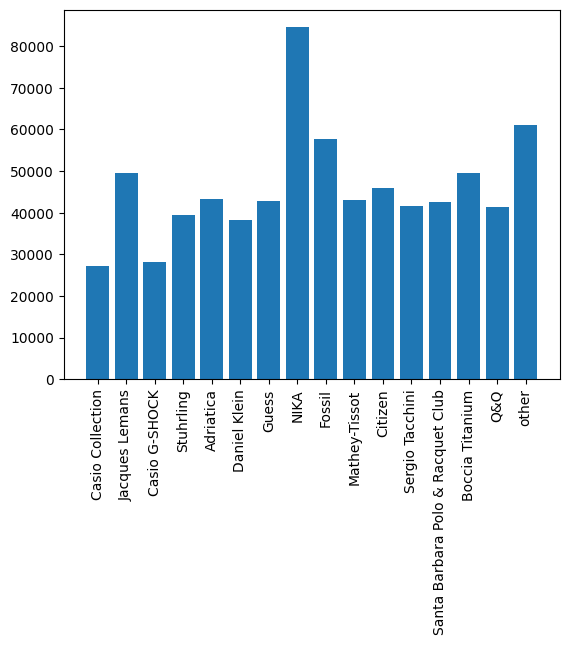

In [67]:
# чтобы построить столбчатую диаграмму надо вынести большую часть брендов в "others", так как их слишком много
# вынесем туда те, которые встречаются наиболее редко

brand_number = 15 # сколько брендов рассматриваем

group_watches = watches.groupby(['brand']).agg(agg_params)
sort_watches = group_watches.sort_values(by=[("model", "count")], ascending = False)
name = [str(i) for i in sort_watches.index[:brand_number]]+["other"]
mid_price=list(sort_watches["price"]["mean"])
plt.bar(range(len(name)), mid_price[:brand_number]+[sum(mid_price[brand_number:]) / (len(mid_price) - brand_number)])
plt.xticks(range(len(name)), name, rotation=90)

# Вывод
- Наиболее распространенные часы Casio - любимая всеми марка, к тому же являющаяся бюджетной
- Гипотеза частично подтвердилась - в топе популярности как недорогие часы, так и подороже (Jacques Lemans, NIKA)

# Что влияет на цену
Используем машинное обучение (регрессию), чтобы выяснить, какие параметры и как влияют на цену

In [24]:
# построим регрессию, чтобы предсказывать цены на часы и понять, какой из параметров сильнее всего влияет на стоимость
encoder = ce.cat_boost.CatBoostEncoder()
columns = list(watches.columns)
encoder.fit(watches[columns], watches[columns[2]])
transformed_data = encoder.transform(watches[columns])
transformed_data.head()
# мы видим, что декодировать модель часов нормально не получилось - это логично, так как каждая модель уникальна
# в будущем просто не будем использовать этот параметр для регрессии

,brand,model,price,sex,country,mechanism,water resistance,glass
0,30648.728089,48596.975244,15750,47516.576465,50799.074008,44884.961705,47191.229422,44633.088692
1,41385.975802,48596.975244,21000,47516.576465,52492.817489,44884.961705,49673.086561,56066.883209
2,41385.975802,48596.975244,34750,49284.263040,52492.817489,44884.961705,49673.086561,56066.883209
3,38612.471134,48596.975244,14600,49284.263040,46174.649785,44884.961705,47191.229422,44633.088692
4,28300.847006,36705.658415,30760,49284.263040,35220.221653,44884.961705,40401.565386,44633.088692


In [25]:
# обучаю модель для предказания цены и определения важности параметров
# необходимо подобрать оптимальные значения 3 параметров модели, чтобы минимизировать MSE
iterations=5
learning_rate=0.1
depth=10

X = transformed_data[columns[:1]+columns[3:]]
y = transformed_data[columns[2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
cat = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth)
cat.fit(X_train, y_train)
mean_squared_error(y_test, cat.predict(X_test))
# параметры подобраны!

0:	learn: 127173.5602437	total: 111ms	remaining: 442ms
1:	learn: 126404.3730789	total: 119ms	remaining: 179ms
2:	learn: 125706.6114758	total: 126ms	remaining: 84.2ms
3:	learn: 125105.1995862	total: 133ms	remaining: 33.3ms
4:	learn: 124532.3714138	total: 141ms	remaining: 0us


14598228546.35635

([<matplotlib.axis.XTick at 0x265f9c9e080>,
 [Text(0, 0, 'brand'),
  Text(1, 0, 'sex'),
  Text(2, 0, 'country'),
  Text(3, 0, 'mechanism'),
  Text(4, 0, 'water resistance'),
  Text(5, 0, 'glass')])

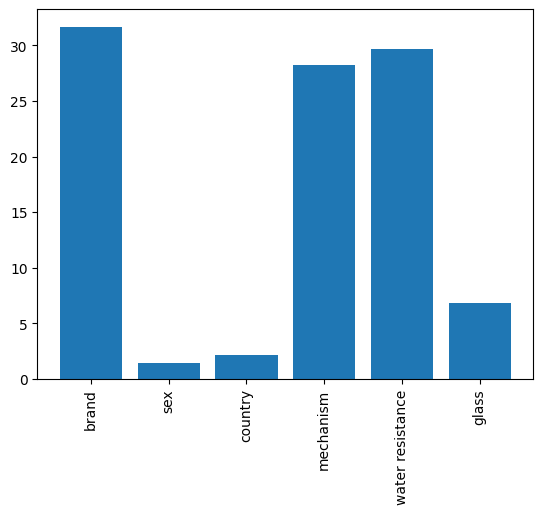

In [26]:
feature_importance = cat.get_feature_importance()
name = columns[:1]+columns[3:]
plt.bar(range(len(name)), feature_importance)
plt.xticks(range(len(name)), name, rotation=90)

# Вывод: 
- наиболее важным параметром является бренд (кто бы мог подумать)
- пол очевидно не влияет на цену
- страна влияет очень слабо, так как бренд по определению относится к определенной стране
- механизм и защита от воды влияют тоже сильно - это очень важные технические параметры, определяющие долговечность и удобство часов
- а вот то что тип стекла слабо влияет на цену оказалось сюрпризом - разные стекла имеют кардинальную разницу в стоимости изготовления и прочности 

# Водозащита и механизм
Рассмотрим подробнее те 3 параметра, которые влияют на цену больше всего. Попробуем выяснить ожидаемые параметры часов в зависимости от бюджета - какой механизм и степень водозащиты скорее всего получит человек, решивший потратить N денег на часы. Также сможем узнать самые распространенные параметры на рынке, так как уже знаем, что недорогие часы наиболее популярны

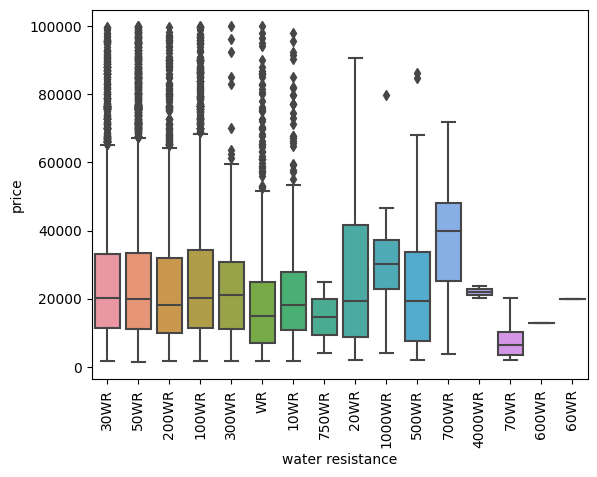

In [133]:
watches_wr = watches[watches['price']<100000] # все часы дороже будут выбросами относительно водозащиты
watches_wr = watches_wr[watches_wr['water resistance'] != '']
ax = sns.boxplot(x='water resistance', y='price', data=watches_wr)
ax.tick_params(axis='x', rotation=90)

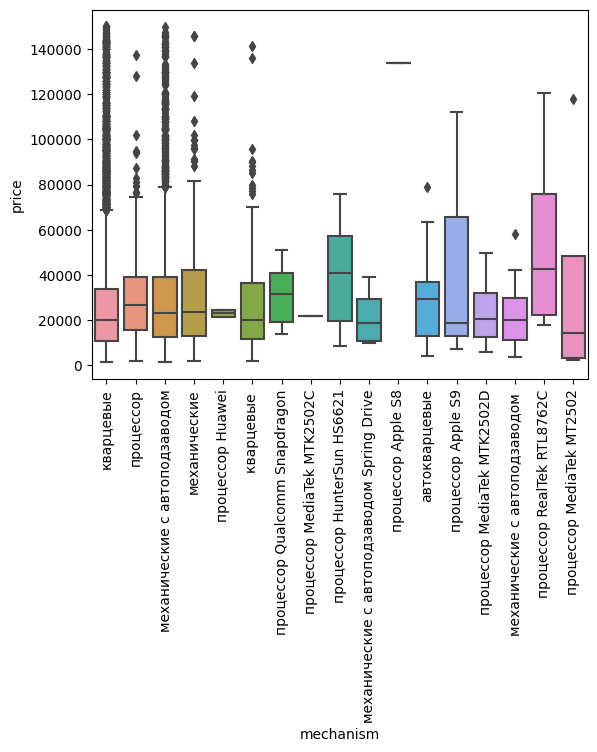

In [130]:
watches_mech = watches[watches['price']<150000] # все часы дороже будут выбросами относительно типа механизма
watches_mech = watches_mech[watches_mech['mechanism'] != '']
ax = sns.boxplot(x='mechanism', y='price', data=watches_mech)
ax.tick_params(axis='x', rotation=90)

# Вывод
Мы видим, что даже в недорогом ценовом сегменте (меньше 40к) можно найти часы с любыми нужными параметрами, за исключением некоторых особых процессоров

Значит, хоть эти параметры без сомнения влияют на цену - их влияние довольно слабо. 

Это означает, что единственным действительно важным фактором является бренд - его история, дизайн и собственный механизм (механические часы разные фирмы делают по разному)

# Бренд
Рассмотрим отдельно бренд часов. Для начала выясним, как зависит престижность бренда, а значит и цена продукта от страны изготовления

## Количество брендов в стране

In [52]:
# чтобы получить координаты стран через geopy необходимо, чтобы они были записаны по английски
# для этого используем переводчик от гугла, а после присваиваем координатам каждой страны значение средней цены или количества брендов
tr = Translator()
geolocator = Nominatim(user_agent="bytescout", timeout=None)

agg_params = {
    "brand" : ["count"],
    "price" : ["mean"],
}
country_watches = watches.groupby(['country']).agg(agg_params)

map_brand = folium.Map()
country_brand = []
country_price = []
for i in range (len(country_watches.index)):
    if country_watches.index[i] != '':
        loc = tr.translate(country_watches.index[i], dest='en').text
        geoloc = geolocator.geocode(query = loc)
        country_brand.append([geoloc.latitude, geoloc.longitude, float(country_watches["brand"]["count"][i])])
        country_price.append([geoloc.latitude, geoloc.longitude, float(country_watches["price"]["mean"][i])])
HeatMap(country_brand).add_to(map_brand)
map_brand

## Средняя цена часов из определенной страны

In [56]:
map_price = folium.Map()
HeatMap(country_price).add_to(map_price)
map_price

# Вывод
- Бесспорным лидером является Швейцария - в ней наибольшее количество брендов и стоимость часов
- По количеству часовых брендов также выделяется Япония - их бренды не такие старые, но сумели быстро завоевать рынок и любовь покупателей
- А по стоимости часов выделяются 3 страны: Великобритания, Китай и Россия - в этих странах не так много марок часов, но все оставшиеся бренды узнаваемы и имеют свою историю 

# Итог
- Стоимость часов обуславливается именно брендом
- Все остальные параметры способны оказывать сильное влияние на стоимость лишь внутри отдельного бренда
- За исключением Швейцарии (часы из которой априори считаются качественными и престижными) страна также не влияет на стоимость
- Наиболее распространены недорогие, но качественные часы - поэтому в топе популярности именно Casio
- В России есть несколько брендов часов, которые продолжают выпускать продукцию, но их мало

Значит, часы из-за рубежа (особенно Швейцарии) продолжат экспортироваться теми или иными способами, так как спрос на часы обуславливается в первую очередь брендом, из-за чего импортозамещение сомнительно 